### Why Do We Use the Functional API in This Transfer Learning Example?

In this notebook, we use **Keras Functional API** instead of the Sequential API because **transfer learning requires more flexibility than a simple stack of layers**.

In our model, we are not building a neural network from scratch. Instead, we are **reusing a pre-trained model (MobileNetV2)** that was trained on ImageNet and **connecting new layers on top of it** to solve a different task (MNIST digit classification).

The architecture of our model looks like this:

Input Image → Pre-trained MobileNetV2 → Global Average Pooling → Dense (Softmax Output)

The **Sequential API** is designed for very simple models where layers are stacked one after another. It becomes limited when:
- A pre-trained model needs to be inserted inside another model
- Inputs and outputs must be explicitly defined
- We want full control over how data flows through the model

The **Functional API** solves these problems by allowing us to:
- Treat a pre-trained model as a layer
- Explicitly define inputs and outputs
- Build flexible and scalable architectures
- Easily extend the model later (for example, fine-tuning or multiple outputs)

In our code, we explicitly define the input layer and pass it through MobileNetV2:

```python
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)


TensorFlow version: 2.19.0
Train shape: (60000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


/tmp/ipython-input-4003319853.py:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.3851 - loss: 2.0424 - val_accuracy: 0.5459 - val_loss: 1.6186
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5468 - loss: 1.5625 - val_accuracy: 0.5888 - val_loss: 1.3943
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5875 - loss: 1.3745 - val_accuracy: 0.6113 - val_loss: 1.2769
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6079 - loss: 1.2688 - val_accuracy: 0.6249 - val_loss: 1.2030
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6238 - loss: 1.2057 - val_accuracy: 0.6372 - val_loss: 1.1523
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6314 - loss: 1.1551 - val_accuracy: 0.6448 - val_loss: 1.1162
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6406 - loss: 1.1187 - val_accuracy: 0.6481 - val_loss: 1.0890
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6431 - loss: 1.1015 - val_accuracy: 

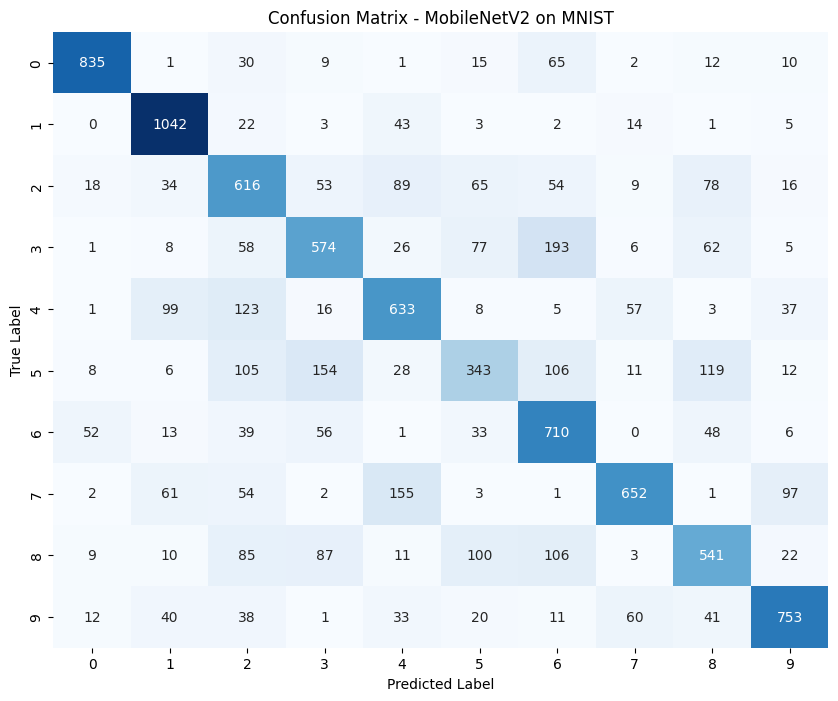

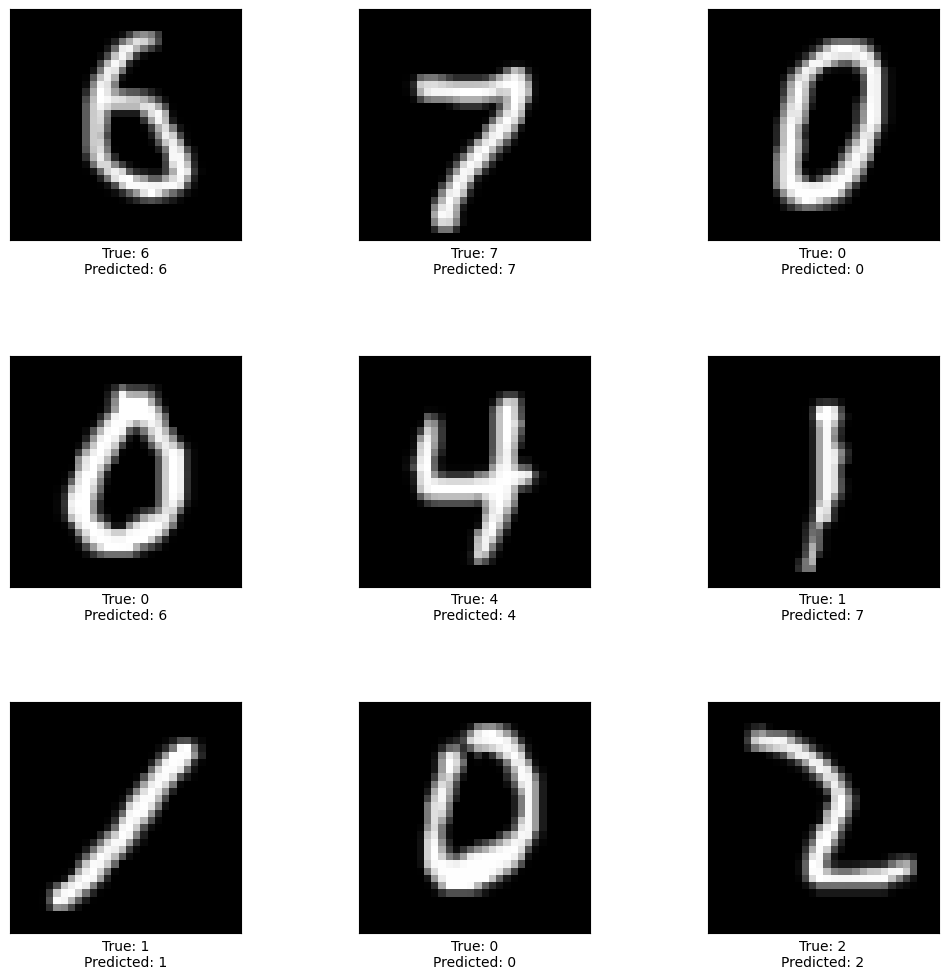

In [ ]:
# ======================================================
# Transfer Learning with MobileNetV2 on MNIST (One Cell)
# Feature Extraction ONLY
# ======================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)

# ------------------------------------------------------
# 1. Load and Prepare the Dataset
# ------------------------------------------------------

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Convert grayscale (28x28) to RGB (28x28x3)
train_images = np.stack([train_images] * 3, axis=-1)
test_images = np.stack([test_images] * 3, axis=-1)

# Normalize
train_images = train_images / 255.0
test_images = test_images / 255.0

# Resize to 32x32
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

# One-hot encode labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print("Train shape:", train_images.shape)
print("Test shape:", test_images.shape)

# ------------------------------------------------------
# 2. Build Transfer Learning Model
# ------------------------------------------------------

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze base model
base_model.trainable = False

inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

# ------------------------------------------------------
# 3. Compile and Train
# ------------------------------------------------------

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_images,
    train_labels,
    epochs=30,
    validation_split=0.2,
    batch_size=128
)

# ------------------------------------------------------
# 4. Evaluate Model
# ------------------------------------------------------

loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# ------------------------------------------------------
# 5. Confusion Matrix
# ------------------------------------------------------

predictions = model.predict(test_images)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MobileNetV2 on MNIST")
plt.show()

# ------------------------------------------------------
# 6. Sample Predictions Visualization
# ------------------------------------------------------

# Convert RGB back to grayscale for display
test_images_gray = np.dot(test_images[..., :3], [0.2989, 0.5870, 0.1140])

def display_samples(images, true_labels, predicted_labels):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_xlabel(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

idx = np.random.choice(len(test_images_gray), 9, replace=False)
display_samples(
    test_images_gray[idx],
    true_classes[idx],
    pred_classes[idx]
)
